# ssp.train.py

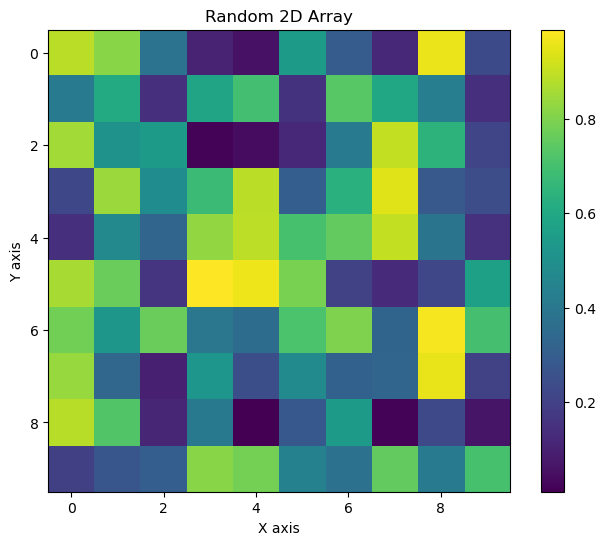

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = 3,
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'

    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'

    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])


    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= f'{gpu}'


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)



    # 모델 초기화
    if SAE_net == False:
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias)
            net = torch.nn.DataParallel(net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[96, 64, 32, 4], decoder_ch=[32,64,96,n_sample], n_sample=n_sample, need_bias=need_bias)
            net = torch.nn.DataParallel(net)
    else:
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = 4, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)
        else:
            net = SAE_fc_only(encoder_ch=[96, 64, 32, 4], 
                                decoder_ch=[32,64,96,n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_annbase_20250106_173037_486.pth'))




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
    
    for epoch in range(max_epoch):

        ae_train_start_time = time.time()
        running_loss = 0.0
        iter = 0
        net.train()
        for data in train_loader:
            optimizer.zero_grad()
            spike_backup = data
            spike = data
            spike = spike.to(device) # batch, feature
            if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                spike = (spike > levels).to(torch.float) 
                # spike: batch, time, level_num
                # levels: time, level_num
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    if two_channel_input == True:
                        spike_backup = spike_backup.to(device)
                        spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_backup = (spike_backup <= levels).to(torch.float) 
                        spike_backup = spike_backup.unsqueeze(-2)
                        spike = torch.cat((spike, spike_backup), dim=-2)
                assert spike.shape[0] == batch_size and spike.shape[1] == TIME
            elif 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
            spike_class = net(spike) # batch, time, feature

            if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                
                # loss1 = nn.MSELoss()(spike_class[:, :, 5:25], spike[:, :, 5:25])
                # loss2 = nn.MSELoss()(spike_class[:, :, 0:5], spike[:, :, 0:5])
                # loss3 = nn.MSELoss()(spike_class[:, :, 25:spike_length], spike[:, :, 25:spike_length])
                # loss = loss1 * 2.125 + (loss2 + loss3)/4
                # assert spike_length > 25, 'spike_length가 25보다 작음'

                # loss1 = nn.MSELoss()(spike_class[:, 5:25, :], spike[:, 5:25, :])
                # loss2 = nn.MSELoss()(spike_class[:, 0:5, :], spike[:, 0:5, :])
                # loss3 = nn.MSELoss()(spike_class[:, 25:TIME, :], spike[:, 25:TIME, :])
                # # loss = nn.MSELoss()(spike_class, spike)
                # loss = loss1 * 2.125 + (loss2 + loss3)/4
                # assert TIME > 25, 'TIME가 25보다 작음'
                
                loss = nn.MSELoss()(spike_class, spike)


            elif 'SAE' in net.module.__class__.__name__:
                loss1 = nn.MSELoss()(spike_class[:, :, 5:25], spike[:, :, 5:25])
                loss2 = nn.MSELoss()(spike_class[:, :, 0:5], spike[:, :, 0:5])
                loss3 = nn.MSELoss()(spike_class[:, :, 25:spike_length], spike[:, :, 25:spike_length])
                loss = loss1 * 2.125 + (loss2 + loss3)/4
                assert spike_length > 25, 'spike_length가 25보다 작음'
            else:
                loss1 = nn.MSELoss()(spike_class[:, 5:25], spike[:, 5:25])
                loss2 = nn.MSELoss()(spike_class[:, 0:5], spike[:, 0:5])
                loss3 = nn.MSELoss()(spike_class[:, 25:spike_length], spike[:, 25:spike_length])
                loss = loss1 * 2.125 + (loss2 + loss3)/4
                assert spike_length > 25, 'spike_length가 25보다 작음'
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
            iter += 1
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초")





        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                
                hidden_size = 4*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else 4

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                
                net.eval()
                with torch.no_grad():
                    spike_torch = torch.from_numpy(spike_template).float()
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    
                    inner_inf = net.module.encoder(spike_torch)

                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(spike_template.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = torch.from_numpy(spike_batch)
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    
                        inner_inf = net.module.encoder(spike_torch)
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                            tau[q] = tau[q] / denominator

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 2), axis=1)

                    m = np.argmin(distance_sm)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16
                
                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time()
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]

            print('cluster_accuracy_post_training_cycle_all_dataset', cluster_accuracy_post_training_cycle_all_dataset)

            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.2f}%")

            if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

# gpu = 3
# Conv_net = True
# SAE_net = True

# # hyperparameter
# dataset_num = 16
# spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
# num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
# training_cycle = 1400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


# batch_size = 32
# max_epoch = 7000
# learning_rate = 0.001
# normalize_on = False # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
# need_bias = False
# # first_layer_no_train = False
# lif_add_at_first = False
# my_seed = 42

# TIME = 30 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
# v_decay = 0.25 # -cor
# v_threshold = 0.25 # -cor
# v_reset = 10000.0 # -cor # 10000이상 일 시 hard reset
# BPTT_on = False # +cor

# SAE_hidden_nomean = True # True False

# current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

# optimizer = 'Adam' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

# coarse_com_mode = True # True False
# coarse_com_config = (2.0, -2.0) # (max, min) (2.0, -2.0) (3.0 -3.0)

# sae_l2_norm_bridge = False # True False
# sae_lif_bridge = True # False True

# accuracy_check_epoch_term = 5
    
# lif_add_at_last = True # True False

# two_channel_input = True # True False

# wandb.init(project= f'spike_sorting just run',save_code=False)


# cluster_train_system( 
#     gpu = gpu,
#     Conv_net = Conv_net,
#     SAE_net = SAE_net,

#     # hyperparameter
#     dataset_num = dataset_num,
#     spike_length = spike_length,
#     num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#     training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#     batch_size = batch_size,
#     max_epoch = max_epoch,
#     learning_rate = learning_rate,
#     normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#     need_bias = need_bias,
#     # first_layer_no_train = False
#     lif_add_at_first = lif_add_at_first,
#     my_seed = my_seed,

#     TIME = TIME, # SAE일 때만 유효
#     v_decay = v_decay,
#     v_threshold = v_threshold,
#     v_reset = v_reset, # 10000이상 일 시 hard reset
#     BPTT_on = BPTT_on,

#     SAE_hidden_nomean = SAE_hidden_nomean,
    
#     current_time = current_time,

#     optimizer = optimizer, #'Adam', 'SGD'

#     coarse_com_mode = coarse_com_mode,
#     coarse_com_config = coarse_com_config, # (max, min)

    
#     sae_l2_norm_bridge = sae_l2_norm_bridge,
#     sae_lif_bridge = sae_lif_bridge,

#     accuracy_check_epoch_term = accuracy_check_epoch_term,
    
#     lif_add_at_last = lif_add_at_last,

#     two_channel_input = two_channel_input,
#     )



In [4]:
# Sweep code


from unittest import TextTestRunner


unique_name_hyper = 'cluster_train_system'
# run_name = 'spike_sorting'
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'bayes', # 'random', 'bayes'
    'name': f'spike_sorting_{sweep_start_time}',
    'metric': {'goal': 'maximize', 'name': 'best_mean_cluster_accuracy_post_training_cycle_all_dataset'},
    'parameters': 
    {
        # "gpu": {"values": [1]},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
        "Conv_net": {"values": [True]}, 
        "SAE_net": {"values": [True]}, 

        "dataset_num": {"values": [16]}, 
        "spike_length": {"values": [50]},  
        "num_cluster": {"values": [4]}, 
        "training_cycle": {"values": [1400, 2400]}, # [1400, 2400]

        "batch_size": {"values": [16,32,48]}, 
        "max_epoch": {"values": [1]}, 
        "learning_rate": {"values": [0.001]},
        "normalize_on": {"values": [False]},
        "need_bias": {"values": [False]}, 

        "lif_add_at_first": {"values": [False]}, # [True, False]
        "my_seed": {"values": [42]}, 

        "TIME": {"values": [50,40,30,20]}, #  [4,6,8,10]
        "v_decay": {"values": [0.25,0.50,0.75,0.875]}, # [0.25,0.50,0.75]
        "v_threshold": {"values": [0.25,0.50,0.75,1.0]}, # [0.25,0.50,0.75]
        "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
        "BPTT_on": {"values": [True, False]},  # [True, False]

        "SAE_hidden_nomean": {"values": [True, False]}, # [True, False]

        # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

        "optimizer": {"values": ['Adam', 'SGD']}, # ['Adam', 'SGD']

        "coarse_com_mode": {"values": [True]}, # ['Adam', 'SGD']
        "coarse_com_config": {"values": [(2.0, -2.0), (3.0, -3.0)]}, # ['Adam', 'SGD']

        "sae_l2_norm_bridge": {"values": [False]}, # [True, False]
        "sae_lif_bridge": {"values": [True]}, # [False, True]
        
        "accuracy_check_epoch_term": {"values": [5]}, 

        "lif_add_at_last": {"values": [True, False]},# [True, False]

        "two_channel_input": {"values": [True, False]},# [True, False]
     }
}


def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    gpu  =  0
    Conv_net  =  wandb.config.Conv_net
    SAE_net  =  wandb.config.SAE_net

    dataset_num  =  wandb.config.dataset_num
    spike_length  =  wandb.config.spike_length
    num_cluster  =  wandb.config.num_cluster
    training_cycle  =  wandb.config.training_cycle

    batch_size  =  wandb.config.batch_size
    max_epoch  =  wandb.config.max_epoch
    learning_rate  =  wandb.config.learning_rate
    normalize_on  =  wandb.config.normalize_on
    need_bias  =  wandb.config.need_bias

    lif_add_at_first  =  wandb.config.lif_add_at_first
    my_seed  =  wandb.config.my_seed


    TIME  =  wandb.config.TIME
    v_decay  =  wandb.config.v_decay
    v_threshold  =  wandb.config.v_threshold
    v_reset  =  wandb.config.v_reset
    BPTT_on  =  wandb.config.BPTT_on

    SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
    current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

    optimizer  =  wandb.config.optimizer

    coarse_com_mode = wandb.config.coarse_com_mode
    coarse_com_config = wandb.config.coarse_com_config # (max, min)

    sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
    sae_lif_bridge = wandb.config.sae_lif_bridge

    accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

    lif_add_at_last = wandb.config.lif_add_at_last

    two_channel_input = wandb.config.two_channel_input

    cluster_train_system( 
        gpu = gpu,
        Conv_net = Conv_net,
        SAE_net = SAE_net,

        # hyperparameter
        dataset_num = dataset_num,
        spike_length = spike_length,
        num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


        batch_size = batch_size,
        max_epoch = max_epoch,
        learning_rate = learning_rate,
        normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
        need_bias = need_bias,
        # first_layer_no_train = False
        lif_add_at_first = lif_add_at_first,
        my_seed = my_seed,

        TIME = TIME, # SAE일 때만 유효
        v_decay = v_decay,
        v_threshold = v_threshold,
        v_reset = v_reset, # 10000이상 일 시 hard reset
        BPTT_on = BPTT_on,

        SAE_hidden_nomean = SAE_hidden_nomean,

        current_time = current_time,

        optimizer = optimizer, #'Adam', 'SGD'

        coarse_com_mode = coarse_com_mode,
        coarse_com_config = coarse_com_config, # (max, min)
        
        sae_l2_norm_bridge = sae_l2_norm_bridge,
        sae_lif_bridge = sae_lif_bridge,

        accuracy_check_epoch_term = accuracy_check_epoch_term,

        lif_add_at_last = lif_add_at_last,
        
        two_channel_input = two_channel_input,
        )
    
# sweep_id = 'ygoj9jt4'
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: ldf7j0tk
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/spike_sorting%20cluster_train_system/sweeps/ldf7j0tk


wandb: Agent Starting Run: sghgu8fh with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_010526_239', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.49767
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739


wandb: Agent Starting Run: 7ap8t335 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_010901_794', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.21638
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.47494
mean_cluster_accuracy_post_training_cycle_all_dataset,0.47494


wandb: Agent Starting Run: dkoscq5i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_011236_334', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()
 

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.49847
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Agent Starting Run: f03m4m6z with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_011615_910', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.09649
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.37982
mean_cluster_accuracy_post_training_cycle_all_dataset,0.37982


wandb: Agent Starting Run: djlah73y with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_011959_732', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.5
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Agent Starting Run: 2mc4km0c with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_012646_652', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.31686
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.3491
mean_cluster_accuracy_post_training_cycle_all_dataset,0.3491


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6zzir204 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_013107_660', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06749
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.51581
mean_cluster_accuracy_post_training_cycle_all_dataset,0.51581


wandb: Agent Starting Run: wj7jt6km with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_013843_431', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.00936
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.51513
mean_cluster_accuracy_post_training_cycle_all_dataset,0.51513


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbnznf12 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_014212_303', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_c

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04566
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55697
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ciamni45 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_014909_125', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04946
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.59124
mean_cluster_accuracy_post_training_cycle_all_dataset,0.59124


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zlx3gbi9 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_015608_544', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.17548
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70724
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70724


wandb: Agent Starting Run: e7i9l317 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_015856_201', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.22036
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739


wandb: Agent Starting Run: 2xh2rez3 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_020154_959', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()


avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06189
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.63677
mean_cluster_accuracy_post_training_cycle_all_dataset,0.63677


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: af02tf7a with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_020614_071', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06208
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55288
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55288


wandb: Agent Starting Run: uycemau8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_021343_234', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02304
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77912
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77912


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 45nusgnd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_022120_220', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02868
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78079
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78079


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yph5e41i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_022852_694', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.16538
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55895
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55895


wandb: Agent Starting Run: lzteuxel with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_023256_948', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02385
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60345
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60345


wandb: Agent Starting Run: 7g0hftzt with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_023552_170', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05547
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50267
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50267


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ky6myynb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.875, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_023922_791', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05394
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50241
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50241


wandb: Agent Starting Run: eellpav4 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_024726_907', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.10278
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7794
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7794


wandb: Agent Starting Run: iq7iw1oo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_025012_273', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07145
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77428
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77428


wandb: Agent Starting Run: uh7iajve with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_025441_398', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()
      (6): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (7): SSBH_DimChanger_for_one_two_decoupling()
      (8): LIF_layer()
      (9): SSBH_DimChanger_for_one_two_coupling()
      (10): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (11): SSBH_DimChanger_for_one_two_decoupling()
      (12): LIF_layer()
      (13): SSBH_DimChanger_for_one_two_coupling()
      (14): SSBH_DimChanger_for_fc()
      (15): Linear(in_features=192, out_features=4, bias=False)
      (16): SSBH_DimChanger_for_one_two_decoupling()
      (17): LIF_layer()
      (18): SSBH_DimChanger_one_two()
    )
    (decoder): 

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.16896
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.46294
mean_cluster_accuracy_post_training_cycle_all_dataset,0.46294


wandb: Agent Starting Run: 2duh9mg1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_025735_724', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04858
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50387
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50387


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t53lpbrg with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_030600_991', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.17097
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33625
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydki2v9u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_030855_444', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06011
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75279
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75279


wandb: Agent Starting Run: clso6squ with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_031149_682', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05362
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.6035
mean_cluster_accuracy_post_training_cycle_all_dataset,0.6035


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jzi82ibq with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_031559_537', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03758
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7443
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7443


wandb: Agent Starting Run: 6m52ljgn with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_032247_244', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.15608
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.72963
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72963


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tfj3nw55 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_032945_073', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.13035
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.53053
mean_cluster_accuracy_post_training_cycle_all_dataset,0.53053


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 023nrm1n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_033720_919', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.08307
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.63319
mean_cluster_accuracy_post_training_cycle_all_dataset,0.63319


wandb: Agent Starting Run: h9g5r09i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_034142_707', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04173
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60025
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60025


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9aiu0ymb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_034825_222', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07802
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77968
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77968


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z8ekmbz0 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_035300_754', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.01164
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71387
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71387


wandb: Agent Starting Run: 07mf74xn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_035600_736', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04125
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58682
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58682


wandb: Agent Starting Run: jaa3f3o7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_040329_979', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02376
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.52074
mean_cluster_accuracy_post_training_cycle_all_dataset,0.52074


wandb: Agent Starting Run: 4u129lwd with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_041050_019', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.15255
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.52675
mean_cluster_accuracy_post_training_cycle_all_dataset,0.52675


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g1mvmjlw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_041440_734', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.1762
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.44604
mean_cluster_accuracy_post_training_cycle_all_dataset,0.44604


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5kbdzfqc with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_041825_411', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.13142
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76961
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76961


wandb: Agent Starting Run: yy28cybl with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_042513_352', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03281
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78707
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78707


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vqpl126m with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_043209_477', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.14194
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.37584
mean_cluster_accuracy_post_training_cycle_all_dataset,0.37584


wandb: Agent Starting Run: j306459y with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_043938_494', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04233
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5943
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5943


wandb: Agent Starting Run: njpo4lh8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_044237_330', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04567
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58329
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58329


wandb: Agent Starting Run: laieq30i with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_044637_720', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.01198
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78194
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78194


wandb: Agent Starting Run: nx9qlwkn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_045044_188', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06756
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58001
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58001


wandb: Agent Starting Run: ndgxm45y with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_045341_921', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04007
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75853
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75853


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1uz89cta with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_045757_354', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05887
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7288
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7288


wandb: Agent Starting Run: 2eq3u4q5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_050225_465', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04147
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60281
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60281


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: as08ryn7 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_050609_158', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.14194
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.36697
mean_cluster_accuracy_post_training_cycle_all_dataset,0.36697


wandb: Agent Starting Run: 6j1yvjt1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_051334_142', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03836
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7036
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7036


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2plxcp1d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_052124_049', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03803
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5949
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 647mx2yn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_052853_393', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.09885
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.47964
mean_cluster_accuracy_post_training_cycle_all_dataset,0.47964


wandb: Agent Starting Run: jgwa3kdt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_053253_539', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04612
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.56526
mean_cluster_accuracy_post_training_cycle_all_dataset,0.56526


wandb: Agent Starting Run: hvt3jzze with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_053715_390', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02634
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58961
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58961


wandb: Agent Starting Run: ggiclkh2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_054521_785', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03296
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.59803
mean_cluster_accuracy_post_training_cycle_all_dataset,0.59803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bc6stjpk with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_055257_177', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04507
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73625
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73625


wandb: Agent Starting Run: 7txmq1uh with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_055701_985', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04452
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.54856
mean_cluster_accuracy_post_training_cycle_all_dataset,0.54856


wandb: Agent Starting Run: yzynxixt with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_060431_111', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05283
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55964
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55964


wandb: Agent Starting Run: ckfgdldu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_060713_374', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03859
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5128
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5128


wandb: Agent Starting Run: wipl75hb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_061349_156', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05747
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.47046
mean_cluster_accuracy_post_training_cycle_all_dataset,0.47046


wandb: Agent Starting Run: vkvymzva with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_061749_934', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03305
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75506
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75506


wandb: Agent Starting Run: pvidw1g3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_062052_947', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06901
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55751
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55751


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tluc0szb with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_062337_573', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.12438
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71695
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71695


wandb: Agent Starting Run: g504pegi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_063107_471', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06635
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60856
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60856


wandb: Agent Starting Run: y2y8ikws with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_063511_296', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07809
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74382
mean_cluster_accuracy_post_training_cycle_all_dataset,0.74382


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 79k8m875 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_063813_911', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.14092
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.57168
mean_cluster_accuracy_post_training_cycle_all_dataset,0.57168


wandb: Agent Starting Run: 7vbxv9dm with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_064158_942', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05808
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76863
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76863


wandb: Agent Starting Run: ei44ij84 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_064457_209', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03248
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.52467
mean_cluster_accuracy_post_training_cycle_all_dataset,0.52467


wandb: Agent Starting Run: ml6vv32t with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_064904_438', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.01164
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71096
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71096


wandb: Agent Starting Run: fp0g6ajg with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_065201_873', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07654
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76912
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76912


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dpsmau1s with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_065537_092', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03771
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.64573
mean_cluster_accuracy_post_training_cycle_all_dataset,0.64573


wandb: Agent Starting Run: 3as2dnhr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_070310_695', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04763
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55882
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55882


wandb: Agent Starting Run: zngkk0ou with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_070559_160', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.08136
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.51467
mean_cluster_accuracy_post_training_cycle_all_dataset,0.51467


wandb: Agent Starting Run: x959zm8j with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_070844_075', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02184
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.56048
mean_cluster_accuracy_post_training_cycle_all_dataset,0.56048


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0738fe8s with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_071150_066', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.10187
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.57426
mean_cluster_accuracy_post_training_cycle_all_dataset,0.57426


wandb: Agent Starting Run: i9ltkhp7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_071446_546', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06912
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.47318
mean_cluster_accuracy_post_training_cycle_all_dataset,0.47318


wandb: Agent Starting Run: 8qxvwrmf with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.875
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.875, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_071755_984', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.09533
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.421
mean_cluster_accuracy_post_training_cycle_all_dataset,0.421


wandb: Agent Starting Run: 2kql0idw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_072139_370', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.08337
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50725
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50725


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7wa1zrd with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_072440_879', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02253
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.52422
mean_cluster_accuracy_post_training_cycle_all_dataset,0.52422


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r5v9emu6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_072854_265', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.1831
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77799
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77799


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tfzej7he with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_073303_059', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05066
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.4634
mean_cluster_accuracy_post_training_cycle_all_dataset,0.4634


wandb: Agent Starting Run: 861frgsy with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.875, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_073729_052', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.08659
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55083
mean_cluster_accuracy_post_training_cycle_all_dataset,0.55083


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pe4sb01l with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_074017_002', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0781
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77517
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77517


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4j8sel8u with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_074324_233', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.13573
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60195
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60195


wandb: Agent Starting Run: olmeujnn with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_075012_005', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.11884
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70238
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70238


wandb: Agent Starting Run: n23yd0at with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_075255_265', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.10856
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.57139
mean_cluster_accuracy_post_training_cycle_all_dataset,0.57139


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzpk90sk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_075533_364', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.08162
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.48315
mean_cluster_accuracy_post_training_cycle_all_dataset,0.48315


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pdsburqu with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_075855_078', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05144
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.57928
mean_cluster_accuracy_post_training_cycle_all_dataset,0.57928


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 27lycz2w with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_080256_672', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.32235
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.47752
mean_cluster_accuracy_post_training_cycle_all_dataset,0.47752


wandb: Agent Starting Run: u8prq26d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_080552_063', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06011
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50935
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50935


wandb: Agent Starting Run: x3fsg8tg with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_080849_883', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.23842
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.34076
mean_cluster_accuracy_post_training_cycle_all_dataset,0.34076


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x3pa8o06 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_081336_081', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03281
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78707
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78707


wandb: Agent Starting Run: hr4ufzrt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_082024_677', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.13633
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78257
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78257


wandb: Agent Starting Run: m87sqnpw with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_082451_019', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02385
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58272
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58272


wandb: Agent Starting Run: i2asfinl with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_082749_854', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.08547
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77586
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77586


wandb: Agent Starting Run: f42u91tv with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_083052_628', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.053
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.59892
mean_cluster_accuracy_post_training_cycle_all_dataset,0.59892


wandb: Agent Starting Run: l4f884av with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_083745_635', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04147
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76737
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76737


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqb3kyms with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_084142_373', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02637
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76722
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76722


wandb: Agent Starting Run: w9i8qow1 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_084829_538', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.34491
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.80038
mean_cluster_accuracy_post_training_cycle_all_dataset,0.80038


wandb: Agent Starting Run: 3c8d5j67 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_085057_963', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04807
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60058
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60058


wandb: Agent Starting Run: lnhzbx6w with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_085503_521', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07214
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nng6ka32 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_085908_708', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.15958
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74273
mean_cluster_accuracy_post_training_cycle_all_dataset,0.74273


wandb: Agent Starting Run: aqfclgmd with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_090145_684', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.16677
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50025
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50025


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/search\": read tcp 10.54.34.5:50790-\u003e10.55.247.53:80: read: connection reset by peer","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/search": read tcp 10.54.34.5:50790->10.55.247.53:80: read: connection reset by peer (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 99xrzho8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_090536_415', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.14132
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77901
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77901


wandb: Agent Starting Run: su8kiom0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_091307_115', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02505
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60663
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60663


wandb: Agent Starting Run: aqwcymml with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_091830_064', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04476
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58401
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58401


wandb: Agent Starting Run: fe0utz0w with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_092256_712', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02354
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7745
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7745


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oi1ur7us with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_092614_136', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05839
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.54539
mean_cluster_accuracy_post_training_cycle_all_dataset,0.54539


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ue67gtus with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_092901_263', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.14502
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73997
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73997


wandb: Agent Starting Run: s2oniu0l with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_093252_311', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07432
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58381
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58381


wandb: Agent Starting Run: 4ikhsevp with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_093638_514', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.49844
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7mgz8isg with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_094340_747', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04452
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71302
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71302


wandb: Agent Starting Run: y6ba8c0k with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_095113_879', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02497
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76889
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76889


wandb: Agent Starting Run: ym581ikn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_095920_273', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04203
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.79025
mean_cluster_accuracy_post_training_cycle_all_dataset,0.79025


wandb: Agent Starting Run: zn5uank0 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_100326_411', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06895
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5945
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5945


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ulwxiq9n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_100721_450', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02529
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.59964
mean_cluster_accuracy_post_training_cycle_all_dataset,0.59964


wandb: Agent Starting Run: vjgdnixq with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_101441_287', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.07376
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.72715
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72715


wandb: Agent Starting Run: 1s2plmij with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_101807_384', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.16608
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.44565
mean_cluster_accuracy_post_training_cycle_all_dataset,0.44565


wandb: Agent Starting Run: nixdb5w2 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_102232_811', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.10439
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5497
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5497


wandb: Agent Starting Run: vsb437sc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_102600_412', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.02505
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60663
mean_cluster_accuracy_post_training_cycle_all_dataset,0.60663


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ag8g62yr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_103048_079', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06756
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58001
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58001


wandb: Agent Starting Run: dt2ytxi8 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_103343_243', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.18345
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.51225
mean_cluster_accuracy_post_training_cycle_all_dataset,0.51225


wandb: Agent Starting Run: 5avpp4c1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_103708_470', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06434
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58644
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58644


wandb: Agent Starting Run: 028ibsrv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_104107_333', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.09655
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5605
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5605


wandb: Agent Starting Run: 5e22ucys with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_104403_047', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03289
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77703
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77703


wandb: Agent Starting Run: 1t0d810r with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_105055_229', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04543
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.58089
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58089


wandb: Agent Starting Run: 6htfkmvl with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_105519_389', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.03461
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73955
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73955


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vcgtwe7b with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_110217_120', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [3, -3]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.05775
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.82893
mean_cluster_accuracy_post_training_cycle_all_dataset,0.82893


wandb: Agent Starting Run: 3b4nrws7 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_110559_110', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling()
 

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.5
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33739


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ceev6xrv with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_111314_319', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling(

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.14571
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.54866
mean_cluster_accuracy_post_training_cycle_all_dataset,0.54866


wandb: Agent Starting Run: 3jt35omi with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_111558_884', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.46443
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.50537
mean_cluster_accuracy_post_training_cycle_all_dataset,0.50537


wandb: Agent Starting Run: ao5xa8e0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_111942_318', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_couplin

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.1811
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.47254
mean_cluster_accuracy_post_training_cycle_all_dataset,0.47254


wandb: Agent Starting Run: jhtvtbp9 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_112256_985', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.21058
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.34772
mean_cluster_accuracy_post_training_cycle_all_dataset,0.34772


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hu49v369 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_113036_920', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupli

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.5
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 05oj218e with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_113736_396', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': True, 'coarse_com_config': [3, -3]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupl

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04475
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71407
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71407


wandb: Agent Starting Run: xfh7fzhs with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_114511_885', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [4, 9, 19, 40]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_cou

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.06822
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.57388
mean_cluster_accuracy_post_training_cycle_all_dataset,0.57388


wandb: Agent Starting Run: imtvlvxg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 50
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 48
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 48, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 50, 'v_decay': 0.875, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': False, 'current_time': '20250108_114756_902', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': True, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [5, 11, 24, 50]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_co

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.04358
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.5954
mean_cluster_accuracy_post_training_cycle_all_dataset,0.5954


wandb: Agent Starting Run: p3cmlcej with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 16
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: True
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 16, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_115108_134', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': True, 'coarse_com_config': [2, -2]}
conv length [1, 4, 9, 20]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(2, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coup

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.16994
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74476
mean_cluster_accuracy_post_training_cycle_all_dataset,0.74476


wandb: Agent Starting Run: nfloa2wv with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: False
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 5
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': False, 'current_time': '20250108_115754_209', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 5, 'lif_add_at_last': False, 'two_channel_input': False, 'coarse_com_config': [2, -2]}
conv length [2, 6, 14, 30]
DataParallel(
  (module): SAE_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_DimChanger_for_one_two_coupling

In [ ]:
wandb.finish() 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pickle
import json

# current_time = '20250102_225243_972'

with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
    data = pickle.load(f)


# JSON으로 저장
with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
    loaded_hyperparameters = json.load(f)

loss_history = data['loss_history']
mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
print(data)
max_acc = 0
for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
    if i[1] > max_acc:
        max_acc = i[1]

# 설정 정보 제목 작성
title = (
    f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
    f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
    f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
    f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
)

# 데이터 리스트와 라벨 설정 (Loss 제외)
data_list = [
    ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
]

# 플롯 생성
fig, ax1 = plt.subplots(figsize=(12, 8))

# 첫 번째 y축: Accuracy 관련 데이터
for label, data in data_list:
    epochs, values = zip(*data)  # epoch, value 분리
    ax1.plot(epochs, values, label=label)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="center right")
ax1.grid(True)

# x축을 정수만 표시하도록 설정
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# 두 번째 y축: Loss History
ax2 = ax1.twinx()
epochs, values = zip(*loss_history)
ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
ax2.set_ylabel("Loss", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="center left")

# 제목 추가
plt.title(title, fontsize=10)
plt.tight_layout()
plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
plt.show()
